In [1]:
from diffusers import StableDiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
from PIL import Image
from diffusers import AutoencoderKL

/home/meegan1/Projects/ML/StabilityDiffuser/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

"device: {}".format(device)

'device: cuda'

In [44]:
model_id = "prompthero/openjourney"

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to(device)                                                                                                                                        

pipeline = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
    )

pipeline.vae = vae
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config)

pipeline.enable_xformers_memory_efficient_attention()

pipeline = pipeline.to(device)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 127357.41it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [52]:
from compel import Compel

compel_proc = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

def get_inputs(prompt, batch_size=1, seed=0):
    generator = [torch.Generator("cpu").manual_seed(i + seed)
                 for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 50
    prompt_embeds = compel_proc(prompts)

    return {"prompt_embeds": prompt_embeds, "generator": generator, "num_inference_steps": num_inference_steps}


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols*w, i//cols*h))
    return grid

In [42]:
prompt = "(chocolate bar)( in a field)++, ultrarealistic, photograph"
# prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"

prompt += ", mdjrny-v4 style"

prompt

'(chocolate bar)( in a field)++, ultrarealistic, photograph, mdjrny-v4 style'

100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


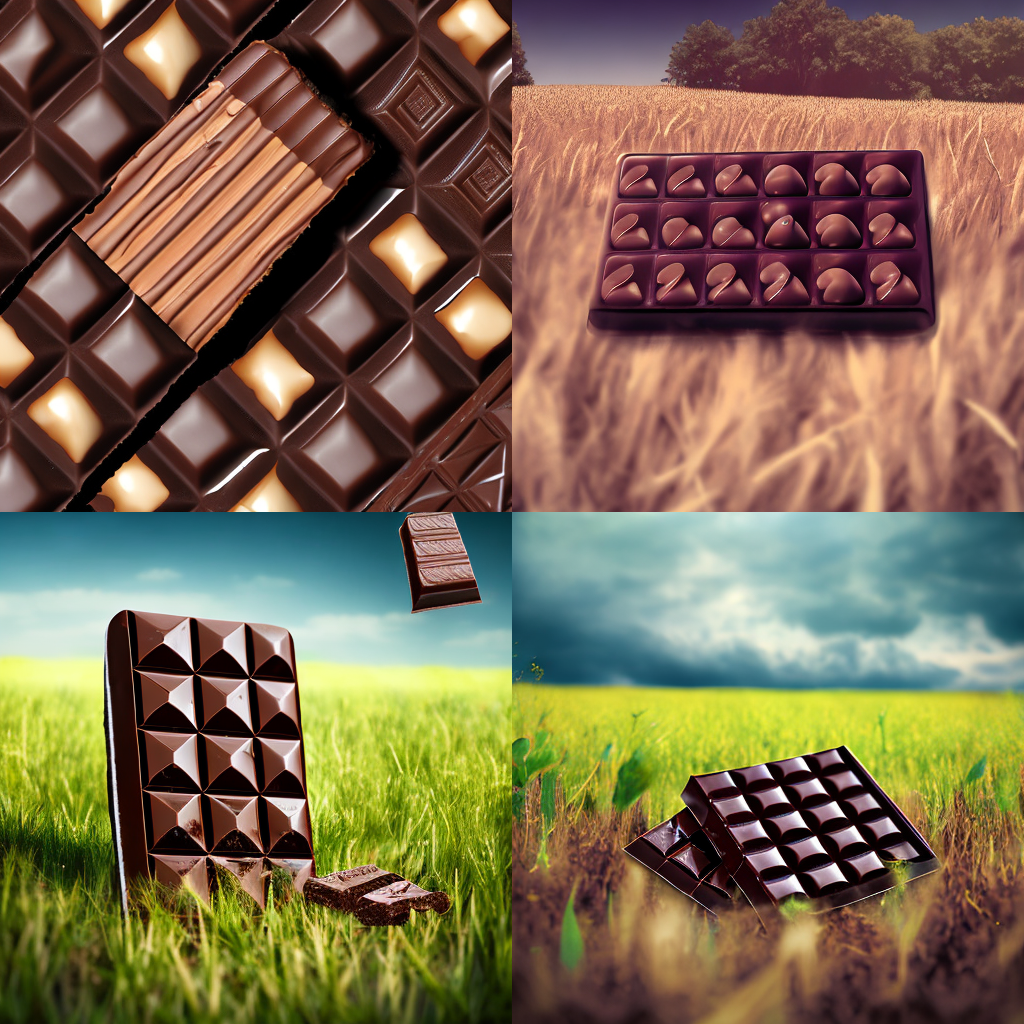

In [54]:
images = pipeline(**get_inputs(prompt=prompt, batch_size=4, seed=0)).images
image_grid(images)